In [1]:
%load_ext autotime

time: 128 µs (started: 2022-06-25 11:02:32 +01:00)


In [2]:
import argparse
import torch
import transformer.Constants as Constants

import re
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem

import tqdm as t
sns.set()

/home/giulio/.miniconda3/envs/main/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


time: 1.07 s (started: 2022-06-25 11:02:32 +01:00)


In [3]:
from typing import List

SMI_REGEX_PATTERN = r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9]|\n)"

class RegexTokenizer:
    """Run regex tokenization"""

    def __init__(self, regex_pattern: str = SMI_REGEX_PATTERN) -> None:
        """Constructs a RegexTokenizer.
        Args:
            regex_pattern: regex pattern used for tokenization.
            suffix: optional suffix for the tokens. Defaults to "".
        """
        self.regex_pattern = regex_pattern
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text: str, bos_token=Constants.BOS_WORD, eos_token=Constants.EOS_WORD) -> List[str]:
        """Regex tokenization.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens separated by spaces.
        """
        tokens = [token for token in self.regex.findall(text)]
        tokens = [bos_token] + tokens + [eos_token]
        return tokens
    
tokenizer = RegexTokenizer()

time: 988 µs (started: 2022-06-25 11:02:33 +01:00)


In [4]:
def build_mapping(smiles_lst):
    tokens = [tokenizer.tokenize(smi) for smi in smiles_lst]
    unique_tokens, unique_counts = np.unique(np.concatenate(tokens), return_counts=True)
    unique_tokens.size

    token2idx = {}

    for i, (t, c) in enumerate(zip(unique_tokens,unique_counts)):
        if c <= 5:
            continue
        else:
            token2idx[t] = i

    special_tokens = [Constants.BOS_WORD, Constants.EOS_WORD, Constants.PAD_WORD, Constants.UNK_WORD]
    for t in special_tokens:
        token2idx[t] = token2idx.get(t, len(token2idx))
        
    return token2idx

time: 4.06 ms (started: 2022-06-25 11:02:33 +01:00)


In [5]:
chembl = pd.read_csv('../transformer/data/chembl_30/chembl_30_chemreps_proc_train.csv.gz').sample(100000)
smiles = chembl.SMILES.values

token2idx = build_mapping(smiles)
idx2token = {i: token for token, i in token2idx.items()}
len(token2idx)

44

time: 3.32 s (started: 2022-06-25 11:02:33 +01:00)


## Build package

In [6]:
def dense_onehot(tokens, token2idx=token2idx):
    ''' Mapping words to idx sequence. '''
    return [token2idx.get(w, token2idx[Constants.UNK_WORD]) for w in tokens]

time: 287 µs (started: 2022-06-25 11:02:37 +01:00)


In [7]:
chembl = pd.read_csv('../transformer/data/chembl_30/chembl_30_chemreps_proc_train.csv.gz').sample(100000, random_state=123)
train_smiles = chembl.SMILES.to_list()

chembl = pd.read_csv('../transformer/data/chembl_30/chembl_30_chemreps_proc_valid.csv.gz').sample(5000, random_state=123)
val_smiles = chembl.SMILES.to_list()

time: 1.73 s (started: 2022-06-25 11:02:37 +01:00)


In [8]:
train_smiles_aug = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), canonical=False, doRandom=True) for smi in t.tqdm(train_smiles)]
train_smiles = list(set(train_smiles + train_smiles_aug))

val_smiles_aug = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), canonical=False, doRandom=True) for smi in t.tqdm(val_smiles)]
val_smiles = list(set(val_smiles + val_smiles_aug))

len(train_smiles), len(val_smiles)

100%|██████████| 5000/5000 [00:00<00:00, 6322.74it/s]


(199815, 9992)

time: 16.6 s (started: 2022-06-25 11:02:38 +01:00)


In [9]:
train_tokens = [tokenizer.tokenize(smi) for smi in train_smiles]
val_tokens   = [tokenizer.tokenize(smi) for smi in val_smiles]

train_onehot = [dense_onehot(t) for t in train_tokens]
val_onehot   = [dense_onehot(t) for t in val_tokens]

time: 2.7 s (started: 2022-06-25 11:02:55 +01:00)


# Train

In [10]:
import torch.utils.data
from transformer.Models import Transformer
from transformer.Optim import ScheduledOptim
from dataset import SeqDataset, paired_collate_fn

import math
import trainer
from trainer import train
import importlib as il
il.reload(trainer)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

time: 53.3 ms (started: 2022-06-25 11:02:58 +01:00)


In [11]:
train_loader = torch.utils.data.DataLoader(
    SeqDataset(
        src_word2idx=token2idx,
        tgt_word2idx=token2idx,
        src_insts=train_onehot,
        tgt_insts=train_onehot),
    num_workers=10,
    batch_size=64,
    collate_fn=paired_collate_fn,
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    SeqDataset(
        src_word2idx=token2idx,
        tgt_word2idx=token2idx,
        src_insts=val_onehot,
        tgt_insts=val_onehot),
    num_workers=10,
    batch_size=64,
    collate_fn=paired_collate_fn,
    shuffle=True)

time: 693 µs (started: 2022-06-25 11:02:58 +01:00)


In [12]:
transformer = Transformer(
    n_src_vocab=len(token2idx),
    n_tgt_vocab=len(token2idx),
    len_max_seq=100,
    d_word_vec=512, d_model=512, d_inner=2048,
    n_layers=6, n_head=8,
    d_k=64, d_v=64,
    dropout=0.1, 
    tgt_emb_prj_weight_sharing=True,
    emb_src_tgt_weight_sharing=True
    ).to(device)

time: 1.62 s (started: 2022-06-25 11:02:58 +01:00)


In [13]:
optimizer = ScheduledOptim(
    torch.optim.Adam(
        filter(lambda x: x.requires_grad, transformer.parameters()),
        betas=(0.9, 0.98), eps=1e-09),
    512, 4000)

time: 928 µs (started: 2022-06-25 11:02:59 +01:00)


### Evaluation with untrained model

In [14]:
val_loss, val_acc = trainer.eval_epoch(transformer, val_loader, device)
print('  - (Validation) ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %'.format(
    ppl=math.exp(min(val_loss, 100)), accu=100*val_acc))

  - (Validation) ppl:  1.00141, accuracy: 1.076 %
time: 17.9 s (started: 2022-06-25 11:02:59 +01:00)


# Train

In [15]:
train(transformer, train_loader, val_loader, optimizer, device, n_epochs=10)

[Info] Training performance will be written to file: ./log//train.log and ./log//valid.log
[ Epoch 0 ]


  - (Training)   ppl:  1.00034, accuracy: 63.802 %, time: 18.492 min


  - (Validation) ppl:  1.00024, accuracy: 73.765 %, time: 0.296 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  1.00018, accuracy: 79.580 %, time: 18.442 min


  - (Validation) ppl:  1.00014, accuracy: 84.526 %, time: 0.297 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  1.00012, accuracy: 86.742 %, time: 18.513 min


  - (Validation) ppl:  1.00009, accuracy: 89.591 %, time: 0.297 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  1.00009, accuracy: 90.152 %, time: 18.495 min


  - (Validation) ppl:  1.00007, accuracy: 91.821 %, time: 0.296 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  1.00007, accuracy: 92.145 %, time: 18.488 min


  - (Validation) ppl:  1.00006, accuracy: 93.173 %, time: 0.295 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  1.00006, accuracy: 93.446 %, time: 18.503 min


  - (Validation) ppl:  1.00005, accuracy: 94.110 %, time: 0.297 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  1.00005, accuracy: 94.340 %, time: 18.499 min


  - (Validation) ppl:  1.00005, accuracy: 94.416 %, time: 0.297 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  1.00004, accuracy: 95.074 %, time: 18.520 min


  - (Validation) ppl:  1.00005, accuracy: 94.985 %, time: 0.296 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  1.00004, accuracy: 95.610 %, time: 18.515 min


  - (Validation) ppl:  1.00005, accuracy: 95.104 %, time: 0.297 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  1.00004, accuracy: 96.036 %, time: 18.491 min


  - (Validation) ppl:  1.00005, accuracy: 94.954 %, time: 0.296 min
time: 3h 8min (started: 2022-06-25 11:03:17 +01:00)


# Evaluate

In [16]:
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
import tqdm as t
RDLogger.DisableLog('rdApp.*')

time: 380 µs (started: 2022-06-25 14:11:17 +01:00)


In [17]:
_ = transformer.eval()

time: 6.42 ms (started: 2022-06-25 14:11:17 +01:00)


In [18]:
def output2smiles(output: torch.Tensor, token2idx=token2idx, drop_first: int=1):
    
    eos_idx = token2idx[Constants.EOS_WORD]
    
    batch_smi = []
    for entry in output:
        entry_tokens = []
        
        for val in entry[drop_first:]:
            if val == eos_idx:
                break
            else:
                entry_tokens.append(idx2token[val])
        batch_smi.append(''.join(entry_tokens))
    return batch_smi

time: 601 µs (started: 2022-06-25 14:11:17 +01:00)


In [19]:
output_smi = []

for batch in t.tqdm(val_loader):
    src_seq, src_pos, tgt_seq, tgt_pos = map(lambda x: x.to(device), batch)
    gold = tgt_seq[:, 1:]
    
    with torch.no_grad():
        pred = transformer(src_seq, src_pos, tgt_seq, tgt_pos).cpu().detach()
        pred = pred.max(1)[1].reshape(gold.shape).numpy()

    output_smi = output_smi + output2smiles(pred, drop_first=0)

100%|██████████| 157/157 [00:18<00:00,  8.72it/s]

time: 18 s (started: 2022-06-25 14:11:17 +01:00)


In [24]:
output_mol = list(map(Chem.MolFromSmiles,output_smi))
output_mol_valid = list(filter(None, output_mol))

fraction_valid = len(output_mol_valid)/len(output_mol)

msg = f'{len(output_mol_valid)}/{len(output_mol)} ({fraction_valid*100:.2f} %)'
print(msg)
!echo "{msg}" > performance.txt

3541/9992 (35.44 %)
time: 689 ms (started: 2022-06-25 14:29:14 +01:00)


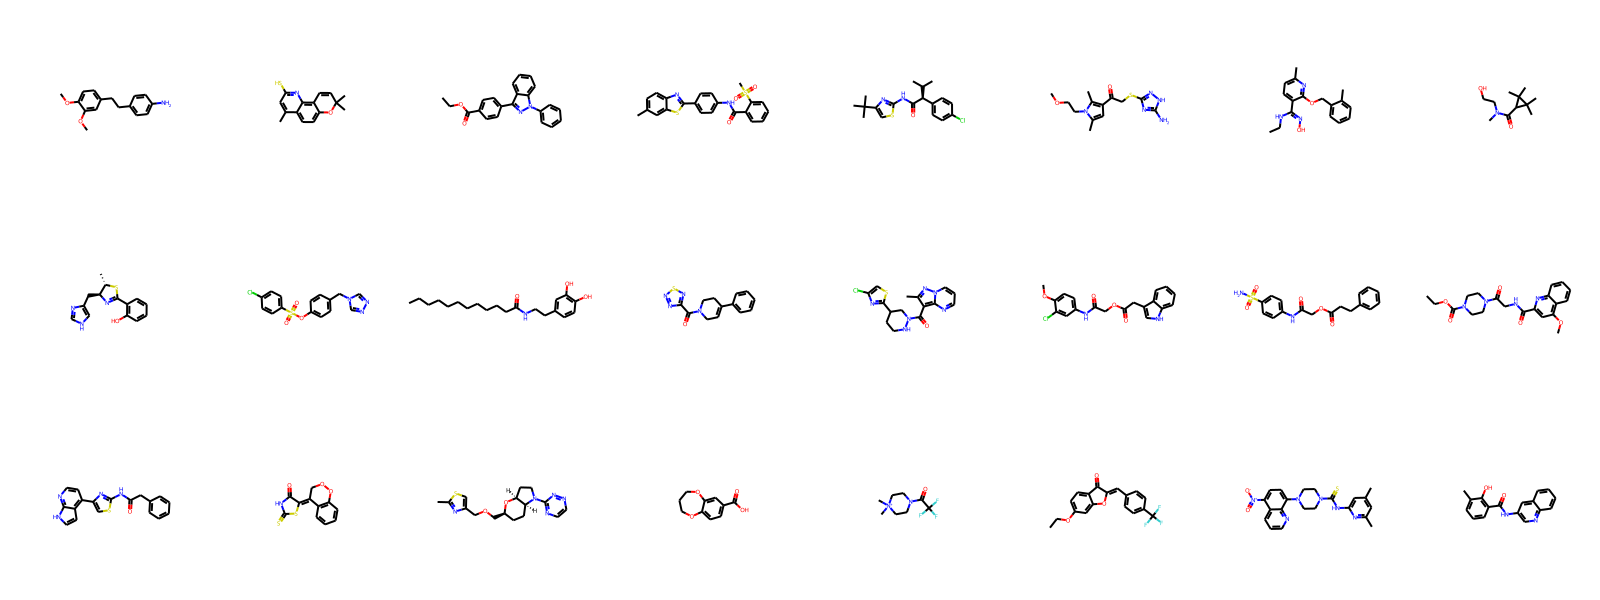

time: 50.4 ms (started: 2022-06-25 14:29:18 +01:00)


In [25]:
Draw.MolsToGridImage(
    np.random.choice(output_mol_valid, 24, replace=False),
    molsPerRow=8
)